# Twitter US Airline Sentiment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [55]:
!pip install contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re, string, unicodedata
import contractions
import nltk
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize                 # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
# Natural language processing tool-kit
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

In [106]:
text_d=pd.read_csv("/content/gdrive/MyDrive/Tweets.csv")
text_d.shape

(14640, 15)

In [107]:
text_d.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [108]:
data=text_d.drop(['tweet_id','airline_sentiment_confidence','negativereason','negativereason_confidence','airline','airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'],axis=1)

Shape of Data is 14640x2

In [109]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head(11)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [110]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head(11)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [111]:
# Check numbers in text
data[data['text'].str.contains('\d+')].head()

,airline_sentiment,text
5,negative,@VirginAmerica seriously would pay $30 a fligh...
7,neutral,@VirginAmerica Really missed a prime opportuni...
10,neutral,@VirginAmerica did you know that suicide is th...
11,positive,@VirginAmerica I <3 pretty graphics. so much b...
12,positive,@VirginAmerica This is such a great deal! Alre...


In [112]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


In [113]:
# Tokenization of data
data['text'] = data.apply(lambda row: word_tokenize(row['text']), axis=1)
data.head()  

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, com..."
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, is, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, is, a, really, big..."


In [114]:
stop_words = stopwords.words('english')

customlist = ['not']

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stop_words = list(set(stop_words) - set(customlist))  
sorted(stop_words) 

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's'

In [115]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    lemmatizer = WordNetLemmatizer()
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience ...
2,neutral,virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


In [116]:
data_features.shape

(14640, 1000)

In [117]:
data['airline_sentiment'] = data['airline_sentiment'].astype('category')
data.dtypes

airline_sentiment    category
text                   object
dtype: object

In [118]:
data['airline_sentiment'] = data['airline_sentiment'].cat.codes
data.head()

,airline_sentiment,text
0,1,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience ...
2,1,virginamerica not today must mean need take an...
3,0,virginamerica really aggressive blast obnoxiou...
4,0,virginamerica really big bad thing


# a.CountVectorizer.

In [119]:
# Vectorization (Convert text data to numbers).
vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(data['text'])
data_features = data_features.toarray()                        # Convert the data features to array.

In [120]:
vectorizer.vocabulary_

{'virginamerica': 941,
 'say': 764,
 'plus': 666,
 'add': 12,
 'experience': 314,
 'not': 601,
 'today': 881,
 'must': 582,
 'mean': 544,
 'need': 587,
 'take': 856,
 'another': 47,
 'trip': 896,
 'really': 708,
 'entertainment': 293,
 'face': 321,
 'little': 512,
 'big': 105,
 'bad': 89,
 'thing': 867,
 'seriously': 779,
 'would': 985,
 'pay': 644,
 'flight': 353,
 'seat': 768,
 'play': 663,
 'fly': 363,
 'yes': 994,
 'every': 301,
 'time': 877,
 'go': 396,
 'away': 84,
 'miss': 570,
 'without': 974,
 'https': 440,
 'well': 965,
 'amaze': 38,
 'arrive': 66,
 'hour': 433,
 'early': 277,
 'good': 399,
 'know': 480,
 'second': 770,
 'lead': 491,
 'pretty': 679,
 'much': 580,
 'better': 103,
 'great': 400,
 'deal': 231,
 'already': 35,
 'think': 869,
 'nd': 586,
 'even': 299,
 'st': 820,
 'yet': 996,
 'sky': 797,
 'travel': 892,
 'http': 439,
 'thank': 866,
 'schedule': 765,
 'still': 831,
 'mia': 556,
 'excite': 308,
 'first': 347,
 'cross': 212,
 'country': 204,
 'lax': 489,
 'mco': 542

In [121]:
labels=data['airline_sentiment']
labels = labels.astype('int')

In [122]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [123]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
print(np.mean(cross_val_score(forest, data_features, labels, cv=5)))

0.6836748633879781


In [124]:
# Predict the result for test data using the model built above.
result = forest.predict(X_test)

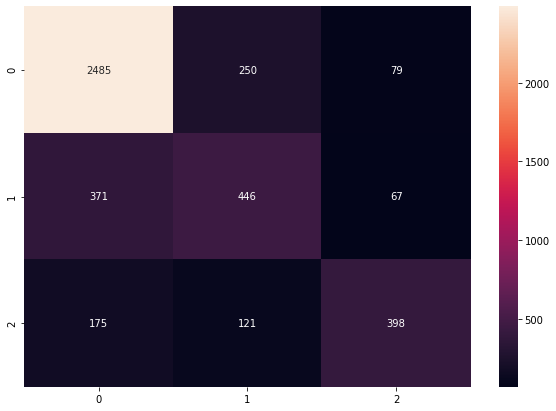

In [126]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

I updated the sentiment score on the scale of 0 to 2, 0=Negative, 1= Neutral and 2= Positive. Cont verctorizer's score is 0.68. Looks like the score loweing is mainly becase of the miss classifictaion between Negative and Nuetral comments. 

# b.TfidfVectorizer.

In [127]:
vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(data['text'])
data_features = data_features.toarray()
data_features.shape

(14640, 1000)

In [128]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [129]:
data_features[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [130]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
print(np.mean(cross_val_score(forest, data_features, labels, cv=5)))

0.690915300546448


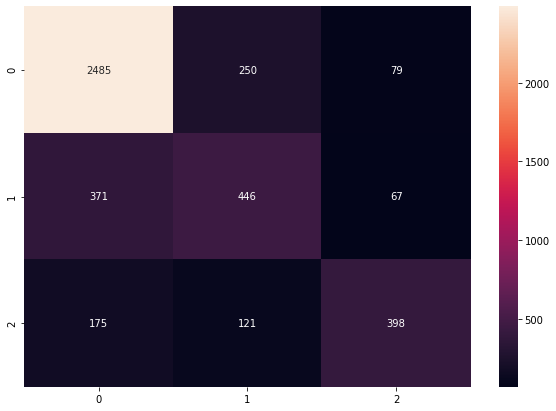

In [131]:
conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

In this classification also I used the same updated sentiment score on the scale of 0 to 2, 0=Negative, 1= Neutral and 2= Positive. Tf-idf verctorizer's score is 0.69. Looks like the score loweing is mainly becase of the miss classifictaion between Negative and Nuetral comments.

There is no considerable change between the scores received from Count vecterizing method and TF-df vectorizing. In both models it is showing that the models having difficulty in recognizing between the negative comments and the nutral comments. We can increase the size of the data pool to improve the traning of the model and hence try improve the score. Also we can try to use diffrent pre processing technique to improve the scores.  